In [1]:
import torch
from torch.nn import functional as F
from config import *
from encoder import Encoder
from modules import LLM

In [2]:
def get_loss_lr(log_file):
    with open(log_file) as f:
        lines = f.readlines()

    losses = []
    lrs = []
    for line in lines:
        step = int(line.split()[0][4:-1])
        loss = float(line.split()[1][5:])
        lr = float(line.split()[3][3:])
        if len(losses) > step - 1:
            losses[step - 1] = loss
            lrs[step - 1] = lr
        else:
            losses.append(loss)
            lrs.append(lr)
    return losses, lrs

In [3]:
import matplotlib.pyplot as plt

1.7960803732275963


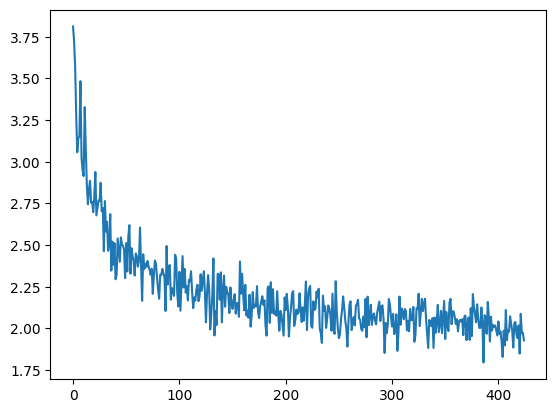

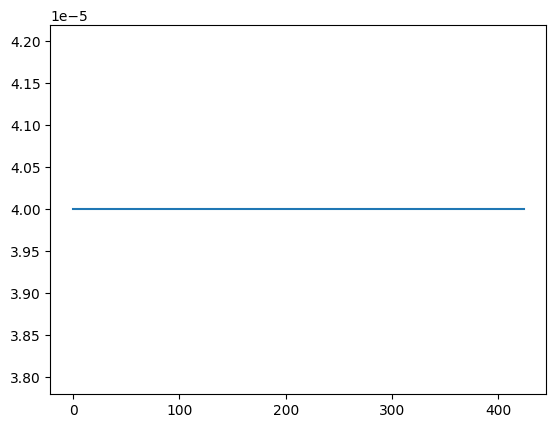

In [4]:
losses, lrs = get_loss_lr("losses_finetune.log")
print(min(losses))
plt.plot(losses)
plt.show()
plt.plot(lrs)
plt.show()

In [5]:
from dataloader import BinaryDataset, collate_fn
from torch.utils.data import DataLoader

loader = DataLoader(
    BinaryDataset("finetune.bin", MAX_LENGTH),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)
encoder = Encoder.from_path("encoder.json")

In [6]:
llm = LLM(encoder.vocab_size, MODEL_DIM, MAX_LENGTH, N_HEADS, N_BLOCKS, 0).to("cuda")
llm = torch.compile(llm)

In [7]:
length = MAX_LENGTH
for x, y, n_tokens in loader:
    x = F.pad(x.to("cuda")[:, :length, ...], (MAX_LENGTH - length, 0), value=0)
    y = F.pad(y.to("cuda")[:, :length, ...], (MAX_LENGTH - length, 0), value=0)
    break

In [8]:
torch.set_float32_matmul_precision("high")
logits = llm(x)
print(loss := F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1)))

tensor(941.9576, device='cuda:0', grad_fn=<NllLossBackward0>)


In [9]:
out = logits[0].argmax(dim=-1).tolist()[MAX_LENGTH - length:]
print(encoder.decode(x[0].tolist()))
print(encoder.decode(y[0].tolist()))
print(encoder.decode(out))

甲：我想买一辆新汽车，请问燃油车和电动车哪个好一些？

乙：与燃油车相比，目前电动车技术已经发展得越来越成熟，电动车的使用成本比燃油车低，维修和保养方面也比较简单。最为重要的是，电动车在行驶过程中产生的空气污染物和碳排放都较少，整体上要更低碳环保，代表了未来汽车的发展方向，推荐购买。

甲：农村的土地价格要更便宜一些，所以更适合建垃圾场吗？

乙：不完全是这样。虽然农村土地价格相对较低，但是垃圾处理需要考虑很多因素和技术水平的问题：  1.地形条件：如果选择在山区或海边建场，可能会影响到建筑物的稳定性和安全性； 2.排水系统：建设一个好的污水排放管道非常重要，这将有助于确保水质达到标准要求并减少污染源的影响； 3.土壤质量：对于一些重金属、有机物质等有害物质来说，存在严重的环境问题，而这些都是建造大型垃圾场的必要成本之一。因此，要建立一个良好的垃圾场必须充分了解当地的环境情况以及可能面临的经济和社会挑战等等。

甲：为什么有人说全球变暖是骗人的？

乙：有些人认为全球变暖是被人为操纵的，因为他们不相信科学证据。例如，2009年11月黑客窃取了多位顶级气候学家的电子邮件中的数据和研究结果都表明太阳活动对地球气候的影响并不只是表面上的扰动而是受到长期天文参数影响的结果。此外，一些科学家也表示这些数据可能不够可靠或者有误导性。

甲：为什么有人说全球变暖是骗人的？

乙：有些人认为全球变暖是骗局，因为他们试图模糊天气和气候这两个不同的概念。虽然科学界已经证实了这种说法是不准确的并且可能对环境造成负面影响，但仍然有一些不科学的证据支持这一理论，例如一些非专业人士提出的假设或未经验证的研究结果等。此外，还有人在2009年11月进行过黑客攻击，从而质疑这个问题的存在性以及其真实性和可信度。

甲：二氧化碳有害吗？

乙：二氧化碳首先对人体有害，过量的二氧化碳会导致呼吸性碱中毒、酸中毒和窒息等症状。此外，地球大气层中的二氧化碳浓度升高还会引起全球变暖，给整个人类社会带来一系列负面的影响。

甲：男的通常要比女的粗心，所以垃圾分类由女的来做会更好一些吗？

乙：不一定，垃圾分类并不是由性别来决定的，而是由每个人的能力和兴趣来决定的。有些人可能比其他人更擅长垃圾分类，而有些人可能不太擅长。重要的是，每个人都应该参与垃圾分类，并尽力确保垃圾分类的正确性。

甲：男的通常要比女的粗心，所

In [11]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.